In [1]:
# Name: Sai Anish Garapati
# UIN: 650208577

## Importing required Libraries

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os, time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as image
from PIL import Image

## Custom Dataset Class

In [3]:
class TrafficImageDatset(Dataset):
	def __init__(self, csv_file, root_dir, transform=None):
		self.csv_content = pd.read_csv(csv_file, usecols=['ClassId', 'Path'])
		self.root_dir = root_dir
		self.transform = transform

	def __len__(self):
		return len(self.csv_content)
	
	def __getitem__(self, index):
		img = Image.open(self.root_dir + self.csv_content.iloc[index, 1])
		label = torch.tensor(int(self.csv_content.iloc[index, 0]))

		if self.transform:
			img_tensor = self.transform(img)
		
		return (img_tensor, label)


## Neural Network Model (ANN)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 43)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Training Function

In [5]:
def train_model(device, model, train_loader, optimizer, epoch, batch_size):
    model.train()
    tot_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, label)
        loss.backward()
        optimizer.step()

        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(label.view_as(predictions)).sum().item()
        tot_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.0 * batch_idx /
                len(train_loader), tot_loss / (batch_idx + 1),
                100.0 * correct / ((batch_idx + 1) * batch_size)))
    print('End of Epoch: {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(
        tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)))

    return tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)

## Validation Function

In [6]:
def validation_model(device, model, validation_loader, batch_size):
    model.eval()
    tot_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(validation_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            tot_loss += torch.nn.CrossEntropyLoss()(output, label).item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(label.view_as(predictions)).sum().item()

    print('Validation Loss: {:.6f}, Validation Accuracy: {:.2f}%'.format(
        tot_loss / len(validation_loader),
        100.0 * correct / (len(validation_loader) * batch_size)
    ))

    return tot_loss/len(validation_loader), 100.0 * correct / (len(validation_loader) * batch_size)

In [7]:
def test_model(device, model, test_loader, batch_size):
    model.eval()
    tot_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            tot_loss += torch.nn.CrossEntropyLoss()(output, label).item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(label.view_as(predictions)).sum().item()

    print('Test Loss: {:.6f}, Test Accuracy: {:.2f}%'.format(
        tot_loss / len(test_loader),
        100.0 * correct / (len(test_loader) * batch_size)
    ))

    return tot_loss/len(test_loader), 100.0 * correct / (len(test_loader) * batch_size)


## Loading Dataset using Dataloader and preprocessing

Train Epoch: 1 [0/33327 (0%)]	Loss: 3.775654, Accuracy: 1.95%
Train Epoch: 1 [25600/33327 (76%)]	Loss: 3.154160, Accuracy: 15.83%
End of Epoch: 1
Training Loss: 2.947421, Training Accuracy: 19.75%
Validation Loss: 2.420239, Validation Accuracy: 27.75%
Test Loss: 2.660950, Test Accuracy: 25.91%
Train Epoch: 2 [0/33327 (0%)]	Loss: 2.295221, Accuracy: 33.20%
Train Epoch: 2 [25600/33327 (76%)]	Loss: 1.834151, Accuracy: 45.82%
End of Epoch: 2
Training Loss: 1.773626, Training Accuracy: 47.32%
Validation Loss: 1.593637, Validation Accuracy: 52.62%
Test Loss: 1.978721, Test Accuracy: 46.77%
Train Epoch: 3 [0/33327 (0%)]	Loss: 1.453717, Accuracy: 53.52%
Train Epoch: 3 [25600/33327 (76%)]	Loss: 1.342162, Accuracy: 60.62%
End of Epoch: 3
Training Loss: 1.312564, Training Accuracy: 61.12%
Validation Loss: 1.307402, Validation Accuracy: 61.63%
Test Loss: 1.735089, Test Accuracy: 55.87%
Train Epoch: 4 [0/33327 (0%)]	Loss: 1.245671, Accuracy: 60.55%
Train Epoch: 4 [25600/33327 (76%)]	Loss: 1.120919,

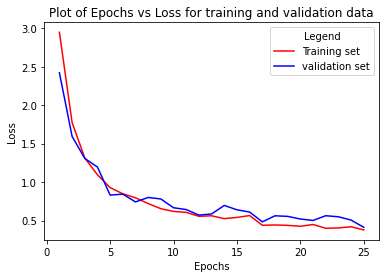

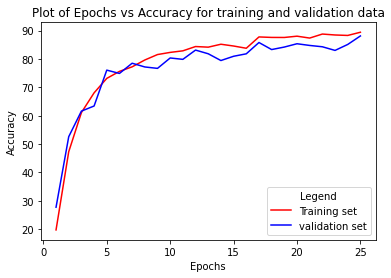

In [13]:
torch.manual_seed(2021)
root_path = '../../../../ML_Project_Data/'
train_batch_size = 256
validation_batch_size = 500
test_batch_size = 1
learning_rate = 0.01

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

train_dataset = TrafficImageDatset(csv_file=root_path + 'Train.csv', root_dir = root_path, transform=transform)
test_dataset = TrafficImageDatset(csv_file=root_path + 'Test.csv', root_dir=root_path, transform=transform)

training_length = int(0.85 * len(train_dataset))
validation_length = len(train_dataset) - training_length

train_set, validation_set = torch.utils.data.random_split(train_dataset, [training_length, validation_length])

train_loader = DataLoader(dataset=train_set, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=validation_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = StepLR(optimizer, step_size=8, gamma=0.8)

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []
test_loss = []
test_accuracy = []

start_time = time.time()
for epoch in range(0, 25):
    loss, accuracy = train_model(device, model, train_loader, optimizer, epoch + 1, train_batch_size)
    training_loss.append(loss)
    training_accuracy.append(accuracy)

    loss, accuracy = validation_model(device, model, validation_loader, validation_batch_size)
    validation_loss.append(loss)
    validation_accuracy.append(accuracy)

    loss, accuracy = test_model(device, model, test_loader, test_batch_size)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

    scheduler.step()

print('Training completed in {} seconds'.format(time.time() - start_time))

%matplotlib inline
plt.title('Plot of Epochs vs Loss for training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(list(range(1, len(training_loss) + 1)), training_loss, 'r', label='Training set')
plt.plot(list(range(1, len(validation_loss) + 1)), validation_loss, 'b', label='validation set')
plt.legend(title='Legend')
plt.show()

plt.title('Plot of Epochs vs Accuracy for training and validation data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(training_loss) + 1)), training_accuracy, 'r', label='Training set')
plt.plot(list(range(1, len(validation_loss) + 1)), validation_accuracy, 'b', label='validation set')
plt.legend(title='Legend')
plt.show()

torch.save(model.state_dict(), 'ML_Model.pt')
